In [1]:
# Our primary dataset can be found at:
# https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
# The file is over 500MB - too big for github!

In [2]:
# import dependencies
import pandas as pd
import requests
import os
from dotenv import load_dotenv
import json
import subprocess
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
tmdb_df = pd.read_csv('tmdb_df.csv')
tmdb_df.head(5)

,Unnamed: 0,vote_average,vote_count,release_date,revenue,runtime,budget,imdb_id,popularity,genres,keywords,year,roi
0,1,8.417,32571,2014-11-05,701729206,169,165000000,tt0816692,140.241,"Adventure, Drama, Science Fiction","rescue, future, spacecraft, race against time,...",2014,4.25
1,5,7.606,28894,2016-02-09,783100000,108,58000000,tt1431045,72.735,"Action, Adventure, Comedy","superhero, anti hero, mercenary, based on comi...",2016,13.50
2,6,8.255,27713,2018-04-25,2052415039,149,300000000,tt4154756,154.340,"Adventure, Action, Science Fiction","sacrifice, magic, superhero, based on comic, s...",2018,6.84
3,8,7.906,26638,2014-07-30,772776600,121,170000000,tt2015381,33.255,"Action, Science Fiction, Adventure","spacecraft, based on comic, space, orphan, adv...",2014,4.55
4,15,8.263,23857,2019-04-24,2800000000,181,356000000,tt4154796,91.756,"Adventure, Science Fiction, Action","superhero, time travel, space travel, time mac...",2019,7.87


In [24]:
tmdb_df = tmdb_df[['vote_average', 'vote_count', 'revenue', 'budget', 'imdb_id']]
tmdb_df.head(5)

,vote_average,vote_count,revenue,budget,imdb_id
0,8.417,32571,701729206,165000000,tt0816692
1,7.606,28894,783100000,58000000,tt1431045
2,8.255,27713,2052415039,300000000,tt4154756
3,7.906,26638,772776600,170000000,tt2015381
4,8.263,23857,2800000000,356000000,tt4154796


In [25]:
tmdb_df.dtypes

vote_average    float64
vote_count        int64
revenue           int64
budget            int64
imdb_id          object
dtype: object

In [26]:
df = tmdb_df.copy()

In [28]:
# Convert object columns to appropriate types
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            try:
                df[col] = pd.to_datetime(df[col])
            except ValueError:
                df[col] = df[col].astype('string')

In [29]:
df.dtypes

vote_average           float64
vote_count               int64
revenue                  int64
budget                   int64
imdb_id         string[python]
dtype: object

In [30]:
df2 = df.copy()

In [31]:
df2 = df2[df2['revenue'].notna() & (df2['revenue'] != 0)]
df2 = df2[df2['budget'].notna() & (df2['budget'] != 0)]
df2 = df2[df2['vote_average'].notna() & (df2['vote_average'] != 0)]
df2 = df2[df2['vote_count'].notna() & (df2['vote_count'] != 0)]

In [32]:
df2['roi'] = round(df2['revenue'] / df2['budget'], 2)
df2.head(5)

,vote_average,vote_count,revenue,budget,imdb_id,roi
0,8.417,32571,701729206,165000000,tt0816692,4.25
1,7.606,28894,783100000,58000000,tt1431045,13.50
2,8.255,27713,2052415039,300000000,tt4154756,6.84
3,7.906,26638,772776600,170000000,tt2015381,4.55
4,8.263,23857,2800000000,356000000,tt4154796,7.87


In [33]:
#Bayesian average is a statistical method used to estimate the true rating of a movie, 
#taking into account both the average rating and the number of votes. 
#It helps mitigate the impact of outliers and provides a more reliable estimate.

# Bayesian Average = (vote_count * vote_average + min_count * mean) / (vote_count + min_count)
# v is the number of votes for the movie
# R is the average rating of the movie   
# m is the minimum votes required to be listed in the chart
# C is the mean vote across the whole dataset

C = df2['vote_average'].mean()
m = df2['vote_count'].quantile(0.75)


def weighted_rating(x):
    # Add a small epsilon to prevent division by zero
    epsilon = 1e-10
    v = x['vote_count']
    R = x['vote_average']
    
    # Compute the weighted rating safely
    denominator = v + m + epsilon
    return (v / denominator * R) + (m / denominator * C)

df2.loc[:, 'weighted_rating'] = df2.apply(weighted_rating, axis=1)

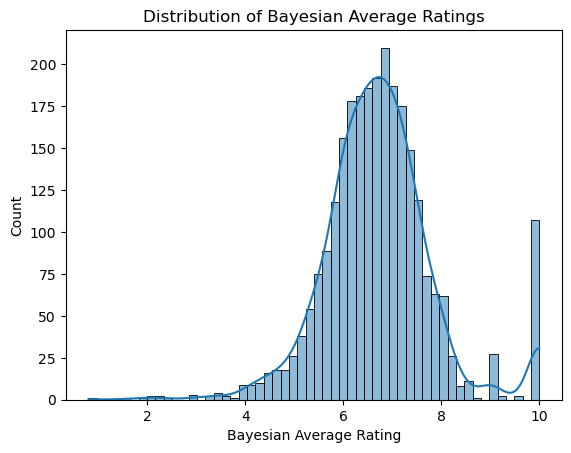

In [34]:
# Visualize the distribution of Bayesian average ratings
sns.histplot(df2['vote_average'], kde=True)
plt.title('Distribution of Bayesian Average Ratings')
plt.xlabel('Bayesian Average Rating')
plt.ylabel('Count')
plt.show()

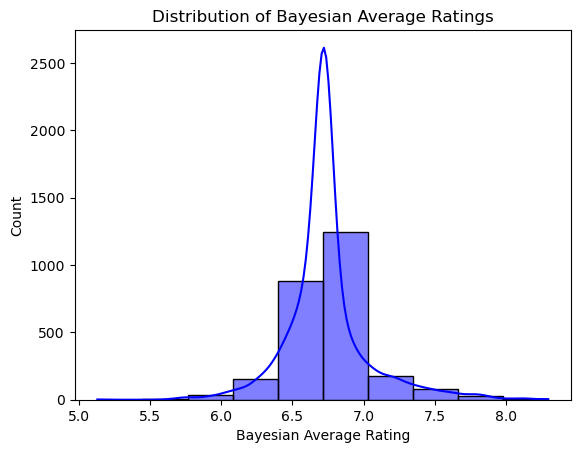

In [35]:
# Visualize the distribution of Bayesian average ratings
sns.histplot(df2['weighted_rating'], kde=True, bins=10, color='blue', edgecolor='black')
plt.title('Distribution of Bayesian Average Ratings')
plt.xlabel('Bayesian Average Rating')
plt.ylabel('Count')
plt.show()



In [37]:
import requests

def get_movie_name(imdb_id):
    # Base URL for the OMDb API
    base_url = "http://www.omdbapi.com/"
    api_key = "c1d0cce2"
    
    # Parameters for the API call
    params = {
        'i': imdb_id,  # IMDb ID
        'apikey': api_key  # Your API Key
    }
    
    # Make the GET request
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()  # Parse JSON response
        if data.get("Response") == "True":
            return data.get("Title")  # Return the movie name
        else:
            return f"Error: {data.get('Error')}"  # Return error message from API
    else:
        return f"HTTP Error: {response.status_code}"



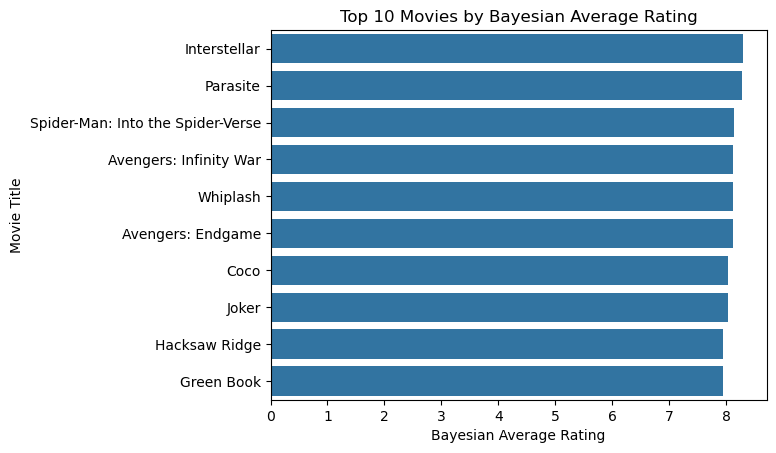

In [38]:
# Plot top 10 movies by Bayesian average
top_10 = df2.sort_values('weighted_rating', ascending=False).head(10)
top_10['movie_name'] = top_10['imdb_id'].apply(lambda x: get_movie_name(x))
top_10.reset_index().head(20)
sns.barplot(x='weighted_rating', y='movie_name', data=top_10)
plt.title('Top 10 Movies by Bayesian Average Rating')
plt.xlabel('Bayesian Average Rating')
plt.ylabel('Movie Title')
plt.show()